# Description
This notebook implements a discrete event simulation-based modelling approach to policy analysis in edge computing networks.

The model emulates a true-to-life edge computing network system consisting of stationary and mobile task requests and a number of CPU-constrained edge computing servers. Task migration is modelled to mimic those tasks that have to move from one server to another due to changes in their distance relative to nearest servers as they journey through the network area.

The simulation has been animated using a network area map with popup markers that indicate the tasks as they are generated in the netwiork area. There are four different types of tasks- mobile, task0, task1 and task2. They all have their attributes- location within the network area, computation time, type of resource that is requested (in this example, only CPU resource is modelled to mimic the CPU that is required for the task computation to be filfilled at the server)

This model is extended from the base model base_model_EdgePolicySim.ipynb. Here a task placement policy is implemented. The task placement policy aims to implement three policies namely: a proximity-aware, a workload-aware and a delay-aware task placement policy

# The flow chart for modelling the task placement policy
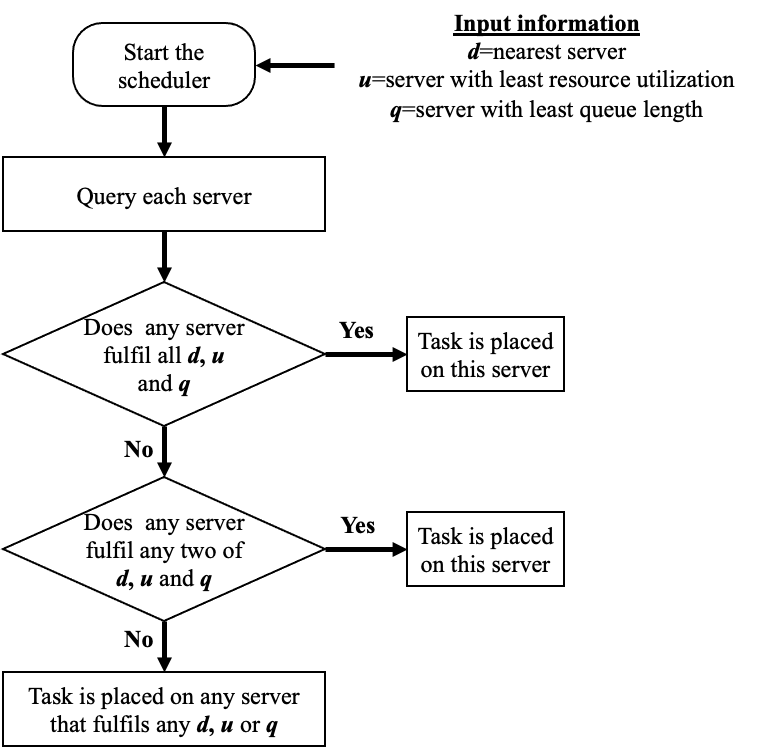

# Install the necessary packages

In [ ]:
# import the map module
from ipyleaflet import (Map, Marker, AwesomeIcon, 
                        Popup, FullScreenControl, AntPath, Icon, WidgetControl)

# import the discrete event simulation module
import salabim as sim

# import package for computing distance
import mpu

# Set up the dynamic map

In [ ]:
# set the center coordinates of the network area
center_lat = 6.515
center_lon = 3.394

In [ ]:
# create the map widget to display the network area
m = Map(center=(center_lat, center_lon), zoom=15)

### Create custom popup icons for the map animation

In [ ]:
# marker colors to differentiate mobile and stationary tasks and to differentiate task status:

# in-queue (black for mobile, blue for stationary)
icon1 = AwesomeIcon(name='fab fa-quora', marker_color='black', icon_color='white')
icon2 = AwesomeIcon(name='fab fa-quora', marker_color='blue', icon_color='white')

# in-process (red for mobile, green for stationary),  
icon3 = AwesomeIcon(name='fas fa-cog', marker_color='red', icon_color='black')
icon4 = AwesomeIcon(name='fas fa-cog', marker_color='green', icon_color='black')

# for finished status, the in-process colors are made opaque (0.2) to mimic task has completed

# icon for marker to show the cell sites on the map, the icon is a cpu tower
icon5 = Icon(icon_url='https://cdn-icons-png.flaticon.com/512/1252/1252852.png', 
             icon_size=[25,30])

# cell site https://image.flaticon.com/icons/png/512/62/62501.png
# cpu tower https://cdn-icons-png.flaticon.com/512/1252/1252852.png

### Set up the server locations and ant path for the mobile task

In [ ]:
# fixed location for server0
server0_lat = 6.518384393755734
server0_lon = 3.3907519935014037

# fixed location for server1
server1_lat = 6.510954681765938
server1_lon = 3.3918624280526357

# fixed location for server2 
server2_lat = 6.512841434002056
server2_lon = 3.3970927353728926

In [ ]:
# markers to indicate the servers
server0 = Marker(location=(server0_lat, server0_lon), icon=icon5)
server1 = Marker(location=(server1_lat, server1_lon), icon=icon5)
server2 = Marker(location=(server2_lat, server2_lon), icon=icon5)

In [ ]:
# add to server markers to the created map
m.add_layer(server0)
m.add_layer(server1)
m.add_layer(server2)

In [ ]:
# add to the map, full screen control
m.add_control(FullScreenControl())

In [ ]:
# add the ant path for the mobile user (task)
ant_path = AntPath(
    locations=[
        [6.51746, 3.387809],  [6.517765, 3.38888],  
        [6.51787, 3.389167],  [6.518012, 3.389444],  [6.518155, 3.389655],  [6.518613, 3.390258],  
        [6.518714, 3.390429],  [6.518853, 3.390723],  [6.518918, 3.390906],  [6.518962, 3.391101],  
        [6.518987, 3.391336],  [6.518953, 3.39136],  [6.518938, 3.391409],  [6.518958, 3.391456],  
        [6.518996, 3.391478],  [6.519081, 3.392472],  [6.519061, 3.392809],  [6.518588, 3.395111],  
        [6.518573, 3.395146],  [6.518581, 3.395172],  [6.518524, 3.395528],  [6.518519, 3.395746],  
        [6.518543, 3.395964],  [6.518633, 3.396351],  [6.518885, 3.396932],  [6.518885, 3.396951],  
        [6.518558, 3.397097],  [6.518337, 3.397163],  [6.51809, 3.397207],  [6.5181, 3.397415],  
        [6.517817, 3.397375],  [6.517817, 3.397375],  [6.517697, 3.397358],  [6.517421, 3.397361],  
        [6.517129, 3.397372],  [6.517122, 3.39718],  [6.516851, 3.397201],  [6.516615, 3.397247],  
        [6.516186, 3.397415],  [6.515613, 3.397588],  [6.515248, 3.39763],  [6.514928, 3.397589],  
        [6.514331, 3.397446],  [6.513938, 3.397392],  [6.513805, 3.397393],  [6.513803, 3.39705],  
        [6.513803, 3.39705],  [6.5138, 3.395799],  [6.513733, 3.395255],  [6.513587, 3.394569],  
        [6.51326, 3.393188],  [6.512997, 3.39195],  [6.512791, 3.391198],  [6.512791, 3.391198],  
        [6.512766, 3.391138],  [6.512776, 3.391118], [6.512986, 3.391188],  [6.515244, 3.39174],  
        [6.515645, 3.39179],  [6.516234, 3.391781],  [6.5174, 3.391643],  [6.5174, 3.391643], 
        [6.518958, 3.391456],  [6.518996, 3.391478],  [6.519062, 3.391459],  [6.519084, 3.391414],  
        [6.518946, 3.390819],  [6.518845, 3.39055],  [6.518786, 3.390418],  [6.518631, 3.390174],  
        [6.518152, 3.38954],  [6.518025, 3.389333],  [6.517852, 3.388948],  [6.51758, 3.388034],  
        [6.517636, 3.387979],  [6.517604, 3.387691], [6.51746, 3.387809],  [6.517765, 3.38888],  
        [6.51787, 3.389167],  [6.518012, 3.389444],  [6.518155, 3.389655],  [6.518613, 3.390258],  
        [6.518714, 3.390429],  [6.518853, 3.390723],  [6.518918, 3.390906],  [6.518962, 3.391101],  
        [6.518987, 3.391336],  [6.518953, 3.39136],  [6.518938, 3.391409],  [6.518958, 3.391456],  
        [6.518996, 3.391478],  [6.519081, 3.392472],  [6.519061, 3.392809],  [6.518588, 3.395111],  
        [6.518573, 3.395146],  [6.518581, 3.395172],  [6.518524, 3.395528],  [6.518519, 3.395746],  
        [6.518543, 3.395964],  [6.518633, 3.396351],  [6.518885, 3.396932],  [6.518885, 3.396951],  
        [6.518558, 3.397097],  [6.518337, 3.397163],  [6.51809, 3.397207],  [6.5181, 3.397415],  
        [6.517817, 3.397375],  [6.517817, 3.397375],  [6.517697, 3.397358],  [6.517421, 3.397361],  
        [6.517129, 3.397372],  [6.517122, 3.39718],  [6.516851, 3.397201],  [6.516615, 3.397247],  
        [6.516186, 3.397415],  [6.515613, 3.397588],  [6.515248, 3.39763],  [6.514928, 3.397589],  
        [6.514331, 3.397446],  [6.513938, 3.397392],  [6.513805, 3.397393],  [6.513803, 3.39705],  
        [6.513803, 3.39705],  [6.5138, 3.395799],  [6.513733, 3.395255],  [6.513587, 3.394569],  
        [6.51326, 3.393188],  [6.512997, 3.39195],  [6.512791, 3.391198],  [6.512791, 3.391198],  
        [6.512766, 3.391138],  [6.512776, 3.391118], [6.512986, 3.391188],  [6.515244, 3.39174],  
        [6.515645, 3.39179],  [6.516234, 3.391781],  [6.5174, 3.391643],  [6.5174, 3.391643], 
        [6.518958, 3.391456],  [6.518996, 3.391478],  [6.519062, 3.391459],  [6.519084, 3.391414],  
        [6.518946, 3.390819],  [6.518845, 3.39055],  [6.518786, 3.390418],  [6.518631, 3.390174],  
        [6.518152, 3.38954],  [6.518025, 3.389333],  [6.517852, 3.388948],  [6.51758, 3.388034],  
        [6.517636, 3.387979],  [6.517604, 3.387691]

    ],
    dash_array=[1, 10],
    delay=1000,
    color='#7590ba',
    pulse_color='#3f6fba'
)

In [ ]:
# add the ant path to the created dynamic map
m.add_layer(ant_path)

In [ ]:
# display the created dynamic map with servers and ant path
m

# The simulation model

In [ ]:
class TaskAttributes(sim.Component):
    """Super class of all task types"""

    def __init__(self, task_type, coord_index, server, process_time, cpu,
                 loc_lat, loc_lon, status_marker, *args, **kwargs):
        sim.Component.__init__(self, *args, **kwargs)
        self.task_type = task_type
        self.coord_index = coord_index
        self.server = server
        self.process_time = process_time
        self.cpu = cpu
        self.loc_lat = loc_lat
        self.loc_lon = loc_lon
        self.status_marker = status_marker

    def process(self):
        """
        Initiate the various task generators to start generating tasks according
        to their respective attributes
        """
        TaskTypeMobile(task_type='mob', coord_index=coord_index_mob, server=server,
                       process_time=process_time_mob, cpu=cpu_mob, loc_lat=loc_lat_mob,
                       loc_lon=loc_lon_mob, status_marker=marker_mob)

        TaskType0(task_type='type0', coord_index=coord_index_0, server=server,
                  process_time=process_time_0, cpu=cpu_0, loc_lat=loc_lat_0, 
                  loc_lon=loc_lon_0, status_marker=marker0)

        TaskType1(task_type='type1', coord_index=coord_index_1, server=server,
                  process_time=process_time_1, cpu=cpu_1, loc_lat=loc_lat_1, 
                  loc_lon=loc_lon_1, status_marker=marker1)

        TaskType2(task_type='type2', coord_index=coord_index_2, server=server,
                  process_time=process_time_2, cpu=cpu_2, loc_lat=loc_lat_2, 
                  loc_lon=loc_lon_2, status_marker=marker2)


class TaskTypeMobile(TaskAttributes):
    def process(self):
        while True:
            # the attributes are changed after each yield that generates a new task
            self.server = server()  # initially assign the generated task to any server as defined by the pdf
            self.coord_index = coord_index_mob()
            self.cpu = cpu_mob()
            
            # create a marker to show the location of the task           
            self.status_marker = Marker(location=(loc_lat_mob, loc_lon_mob))
                                  
            # add the marker to the map
            m.add_layer(self.status_marker)
            
            # display the updated map with the new marker
            m

            # initiate a service request at the server that receives the request
            Service(self.task_type, self.coord_index, self.server, self.process_time, self.cpu,
                    self.loc_lat, self.loc_lon, self.status_marker)

            # discrete time step between each task generation
            yield self.hold(iat_mob())


class TaskType0(TaskAttributes):
    """Class to generate tasks in segment 1"""

    def process(self):
        while True:
            # the attributes are changed after each yield that generates a new task
            self.server = server()  # initially assign the generated task to any server as defined by the pdf
            self.loc_lat = loc_lat_0()
            self.loc_lon = loc_lon_0()
            self.cpu = cpu_0()
            
            # create a marker to show the location of the task           
            self.status_marker = Marker(location=(loc_lat_0(), loc_lon_0()))
                                  
            # add the marker to the map
            m.add_layer(self.status_marker)
            
            # display the updated map with the new marker
            m

            # initiate a service request at the server that receives the request
            Service(self.task_type, self.coord_index, self.server, self.process_time, self.cpu,
                    self.loc_lat, self.loc_lon, self.status_marker)

            # discrete time step between each task generation
            yield self.hold(iat_0())


class TaskType1(TaskAttributes):
    """Class to generate tasks in segment 2"""

    def process(self):
        while True:
            # the attributes are changed after each yield that generates a new task
            self.server = server()  # initially assign the generated task to any server as defined by the pdf
            self.loc_lat = loc_lat_1()
            self.loc_lon = loc_lon_1()
            self.cpu = cpu_1()
            
            # create a marker to show the location of the task           
            self.status_marker = Marker(location=(loc_lat_1(), loc_lon_1()))
                                  
            # add the marker to the map
            m.add_layer(self.status_marker)
            
            # display the updated map with the new marker
            m

            # initiate a service request at the server that receives the request
            Service(self.task_type, self.coord_index, self.server, self.process_time, self.cpu,
                    self.loc_lat, self.loc_lon, self.status_marker)

            # discrete time step between each task generation
            yield self.hold(iat_1())


class TaskType2(TaskAttributes):
    """Class to generate tasks in segment 3"""

    def process(self):
        while True:
            # the attributes are changed after each yield that generates a new task
            self.server = server()  # initially assign the generated task to any server as defined by the pdf
            self.loc_lat = loc_lat_2()
            self.loc_lon = loc_lon_2()
            self.cpu = cpu_2()
            
            # create a marker to show the location of the task           
            self.status_marker = Marker(location=(loc_lat_2(), loc_lon_2()))
                                  
            # add the marker to the map
            m.add_layer(self.status_marker)
            
            # display the updated map with the new marker
            m

            # initiate a service request at the server that receives the request
            Service(self.task_type, self.coord_index, self.server, self.process_time, self.cpu,
                    self.loc_lat, self.loc_lon, self.status_marker)

            # discrete time step between each task generation
            yield self.hold(iat_2())


class Broker(sim.Component):
    """
    In the real world, the broker is updated with status of all servers in the system
    This is modelled using the method network_info
    It is responsible for implementing the task scheduling scheme which is modelled
    as the method, task_scheduling_algorithm
    """

    def __init__(self, task_type, coord_index, server, process_time, cpu, loc_lat, loc_lon, 
                 status_marker, task, *args, **kwargs):
        sim.Component.__init__(self, *args, **kwargs)
        self.task_type = task_type
        self.coord_index = coord_index
        self.server = server
        self.process_time = process_time
        self.cpu = cpu
        self.loc_lat = loc_lat
        self.loc_lon = loc_lon
        self.status_marker = status_marker
        self.task = task
        # add the array objects that will collate information about the servers and their status
        # and is needed for implementing the task placement scheduler
        self.dist = []
        self.utils = []
        self.qlen = []
        self.index_server = 0

    def process(self):
        while True:

            current_server = self.task.server  # the currently assigned server
            self.network_info()  # run the network info
            self.task_scheduling_algorithm()  # run the task scheduling algorithm
            updated_server = self.task.server  # the updated server

            if updated_server != current_server:
                # if the server changes, release the server that was initially seized
                self.task.release()
                # update the server
                self.task.server = updated_server
                # activate or continue the computation in the new server
                self.task.activate()

            yield self.hold(loc_interval_time)  # update server distance every yield event

    def network_info(self):
        """Following code are used to adjust the movement of the mobile task"""
        if self.task_type == 'mob':
            self.coord_index += coord_incr()
            try:
                loc = ant_path.locations[self.coord_index]
            except IndexError:  # avoid end of list range error
                loc = ant_path.locations[-1]  # stop at the last position
            self.loc_lat = loc[0]
            self.loc_lon = loc[1]
            self.status_marker.location = (self.loc_lat, self.loc_lon)

        else:
            self.loc_lat = self.loc_lat
            self.loc_lon = self.loc_lon

        """
        Implement here any computation that needs to be used in the task 
        placement algorithm
        """
        # the broker information to place in the arrays to be used by the scheduling algorithm
        d0 = mpu.haversine_distance((self.loc_lat, self.loc_lon), (server0_lat, server0_lon))
        d1 = mpu.haversine_distance((self.loc_lat, self.loc_lon), (server1_lat, server1_lon))
        d2 = mpu.haversine_distance((self.loc_lat, self.loc_lon), (server2_lat, server2_lon))
        self.dist = [d0, d1, d2]
        self.utils = [server0.occupancy.value, server1.occupancy.value, server2.occupancy.value]
        self.qlen = [len(server0.requesters()), len(server1.requesters()), len(server2.requesters())]


    def task_scheduling_algorithm(self):        
        """Implement here the task placement algorithm (see the clowchart above)"""
        index_d_min = self.dist.index(min(self.dist))
        index_u_min = self.utils.index(min(self.utils))
        index_q_min = self.qlen.index(min(self.qlen))

        if index_d_min == index_u_min == index_q_min:
            self.task.server = servers[index_d_min]
        elif index_d_min == index_u_min:
            self.task.server = servers[index_u_min]
        elif index_u_min == index_q_min:
            self.task.server = servers[index_q_min]
        elif index_q_min == index_d_min:
            self.task.server = servers[index_d_min]
        else:  # random placement in a server that satisfies any one of the objectives
            self.index_server = sim.Pdf((index_d_min, index_u_min, index_q_min), (33, 33, 33)).sample()
            self.task.server = servers[self.index_server]


class Service(sim.Component):
    """Class to process the task"""

    def __init__(self, task_type, coord_index, server, process_time, cpu, 
                 loc_lat, loc_lon, status_marker, *args, **kwargs):
        sim.Component.__init__(self, *args, **kwargs)
        self.task_type = task_type
        self.coord_index = coord_index
        self.server = server
        self.process_time = process_time
        self.cpu = cpu
        self.loc_lat = loc_lat
        self.loc_lon = loc_lon
        self.status_marker = status_marker
        self.request_server = Broker(self.task_type, self.coord_index, self.server,
                                     self.process_time, self.cpu, self.loc_lat, self.loc_lon,
                                     self.status_marker, task=self)  # send task info to broker to decide where to place task

    def process(self):
        time_remain = self.process_time  # set time remaining to process jobs as the process time

        while time_remain > 0:  # as long as remaining time for processing is greater than 0......
            yield self.request((self.server, self.cpu))  # seize the server that is selected in the Broker class
            if self.isclaiming():  # if the task is claiming a server, then continue with processing
                
                if self.task_type != 'mob':
                    # change the icon to green to indicate task is being processed
                    self.status_marker.icon = icon4
                else:
                    self.status_marker.icon = icon3
                
                yield self.hold(time_remain, mode='hold')
                # if the hold was not cancelled, process_time_remain will be set to zero here!assigned the task
                time_remain -= env.now() - self.mode_time()
                
                # change the icon to more opaque so that map is not congested
                self.status_marker.opacity = 0.2  # finised status of the task
                
        self.release()  # release the seized resource
        self.request_server.cancel()  # cancel the request to update the server


# set up the simulation environment
env = sim.Environment(trace=False)

# the resources and their resource usage statistics monitors
server0 = sim.Resource("server 0", capacity=1500)
server1 = sim.Resource("server 1", capacity=1500)
server2 = sim.Resource("server 2", capacity=1500)
servers = [server0, server1, server2]

# starting attributes for the different tasks
# coordinate index to model the journey of the mobile task
coord_index_mob = sim.IntUniform(10, 30)
coord_incr = sim.IntUniform(1, 4)

# coordinate index is not needed by the stationary tasks
# so it is given a value of 0 throughout the simulation
coord_index_0 = 0
coord_index_1 = 0
coord_index_2 = 0


# selected server when task is first generated
server = sim.Pdf((server0, server1, server2), (33, 33, 33))

# the process times are fixed, but they can be modelled as stochastic values
process_time_mob = 50
process_time_0 = 9
process_time_1 = 5
process_time_2 = 2

# stochastic values of the cpu that is requested
cpu_mob = sim.IntUniform(300, 500)
cpu_0 = sim.IntUniform(750, 1000)
cpu_1 = sim.IntUniform(400, 750)
cpu_2 = sim.IntUniform(100, 400)

# location coordinates, latitude and longitude for each task
loc_lat_mob = ant_path.locations[coord_index_mob()][0]
loc_lon_mob = ant_path.locations[coord_index_mob()][1]
loc_lat_0 = sim.Uniform(6.513, 6.518)
loc_lon_0 = sim.Uniform(3.397, 3.4)
loc_lat_1 = sim.Uniform(6.511, 6.518)
loc_lon_1 = sim.Uniform(3.388, 3.397)
loc_lat_2 = sim.Uniform(6.509, 6.513)
loc_lon_2 = sim.Uniform(3.388, 3.398)

# the individual markers
marker_mob = Marker(location=(6.51746, 3.387809), icon=icon1)
marker0 = Marker(location=(6.513, 3.397), icon=icon2)
marker1 = Marker(location=(6.511, 3.388), icon=icon2)
marker2 = Marker(location=(6.509, 3.388), icon=icon2)

# frequency of checking location of the mobile task
loc_interval_time = 5

# the inter arrival times for each type of task
iat_mob = sim.Poisson(12)
iat_0 = sim.Poisson(9)
iat_1 = sim.Poisson(5)
iat_2 = sim.Poisson(3)

# start the simulation with by invoking the TaskAttributes class
TaskAttributes(task_type='mob', coord_index=coord_index_mob, server=server,
                   process_time=process_time_mob, cpu=cpu_mob, loc_lat=loc_lat_mob,
                   loc_lon=loc_lon_mob, status_marker=marker_mob)

# animate the simulation environment
# env.animate(True)

# set the animation speed (it can be adjusted later in the dashboard)
env.speed(.5)

# display the animation menu before simulation starts
# env.an_menu()

# run the simulation for the specified time units
env.run(300)


# Scroll up to the map to view the simulation during run time.
# If env.animate is not disabled then wait a few seconds for the salabim canvas to load